In [1]:
#@title Hide TFP Warnings { display-mode: "form" }
######### Avoid TypeCheck Warning #########
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())
############################################

In [2]:
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns

from ipywidgets import interact
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
#@title Bayes theorem (3Blue1Brown)
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/HZGCoVF3YvM" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Bernoulli distribution

In [4]:
bernoulli = tfd.Bernoulli(probs=0.3)
bernoulli

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[] event_shape=[] dtype=int32>

In [5]:
print(f"Probability of 1: {bernoulli.prob(1):.2f}")
print(f"Probability of 0: {bernoulli.prob(0):.2f}")

Probability of 1: 0.30
Probability of 0: 0.70


### Probability Mass Function (PMF) 

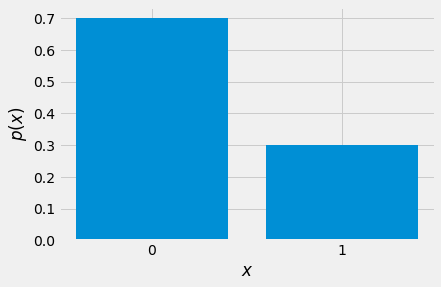

In [6]:
support = [0, 1]
probs = bernoulli.prob(support)
plt.bar(support, probs)
plt.xticks([0, 1])
plt.xlabel("$x$")
plt.ylabel("$p(x)$");

### Sampling from bernoulli distribution

In [7]:
seed = jax.random.PRNGKey(0)
sample = bernoulli.sample(seed=seed)
sample

DeviceArray(0, dtype=int32)

In [8]:
samples = bernoulli.sample(seed=seed, sample_shape=(10,))
samples

DeviceArray([0, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=int32)

In [9]:
samples = bernoulli.sample(seed=seed, sample_shape=(10000,))

In [10]:
(samples == 1).sum()

DeviceArray(2992, dtype=int64)

In [11]:
(samples == 0).sum()

DeviceArray(7008, dtype=int64)

### Sampling I.I.D.

In [12]:
bernoulli = tfd.Bernoulli(probs=0.4)

N = 10
for i in range(N):
  seed = jax.random.PRNGKey(i)
  sample = bernoulli.sample(seed=seed)
  print(sample, end=" ")

0 1 0 0 1 0 0 0 0 0 

In [13]:
seed = jax.random.PRNGKey(1)
samples = bernoulli.sample(seed=seed, sample_shape=(N,))
samples

DeviceArray([0, 1, 1, 0, 0, 1, 0, 0, 1, 0], dtype=int32)

## Coin Toss Problem

In [14]:
coin_toss_data = jnp.array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1])
coin_toss_data

DeviceArray([1, 0, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

We want to determine the probability (likelihood) of $D=\{H,T,H,H,H,H,T,H,H,H\}$ after 10 coin flips believing that we have an unfair coin ($p(H)=\theta=0.3$).

$$
p(D|\theta) = \prod\limits_{i=1}^{10}p(D_i|\theta) = (0.3)^8(0.7)^2
$$

More generally, out of N experiments, if we see $h$ heads, likelihood $p(D|\theta)$ is,

$$
p(D|\theta) = (\theta)^h(1-\theta)^{N-h}
$$

### Maximum Likelihood Estimation (Analytical solution)

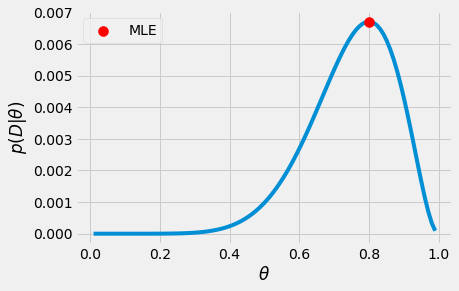

In [15]:
theta_range = jnp.linspace(0.01, 0.99, 100)
def get_prob(theta):
  return tfd.Bernoulli(probs=theta).prob(coin_toss_data).prod()
probs = jax.vmap(get_prob)(theta_range)
plt.plot(theta_range, probs);
plt.scatter([0.8], tfd.Bernoulli(probs=0.8).prob(coin_toss_data).prod(), c='r', s=100, zorder=10, label="MLE");
plt.legend();
plt.xlabel(r'$\theta$')
plt.ylabel(r"$p(D|\theta)$");

We know that the following claim is true for any differentiable function,

* $\theta$ would be optimal at $\frac{d}{d\theta}L(D|\theta)=0$

Let us find out optimal $\theta$:

\begin{align}
p(D|\theta) &= (\theta)^h(1-\theta)^{N-h}\\
\log p(D|\theta) &= h\log(\theta)+(N-h)\log(1-\theta)\\
\frac{d}{d\theta}\log p(D|\theta) &= \frac{h}{\theta} - \frac{N-h}{1-\theta} = 0\\
\\
\text{follows that,}\\
h(1-\theta)-(N-h)\theta &= 0\\
h - h\theta - N\theta + h\theta &= 0\\
\theta_{optimal} &= \frac{h}{N}
\end{align}

In [16]:
N = len(coin_toss_data)
h = (coin_toss_data == 1).sum()
print(f"Optimal: {h/N:.2f}")

Optimal: 0.80


### Question: Is this Optimal a Maxima or Minima?

* $\theta$ would be maximum if $\frac{d^2}{d\theta^2}\log L(D|\theta)<0$.

\begin{align}
\frac{d}{d\theta}\log p(D|\theta) &= \frac{h}{\theta} - \frac{N-h}{1-\theta}\\
\frac{d^2}{d\theta^2}\log p(D|\theta) &= -\frac{h}{\theta^2}-\frac{N-h}{(1-\theta)^2} < 0
\end{align}

Double differentiation is negative and thus our optima is the maxima.

### Maximum Likelihood Estimation (Solution via optimization)

In [17]:
def neg_log_likelihood_fn(theta, data):
  likelihood = tfd.Bernoulli(probs=theta)
  log_prob = likelihood.log_prob(data)
  return -log_prob.sum()

In [18]:
grad_fn = jax.grad(neg_log_likelihood_fn)
theta = 0.1
n_iters = 100
learning_rate = 0.001

losses = []
for iteration in range(n_iters):
  loss = neg_log_likelihood_fn(theta, coin_toss_data)
  losses.append(loss)

  grad = grad_fn(theta, coin_toss_data)
  theta = theta - learning_rate * grad

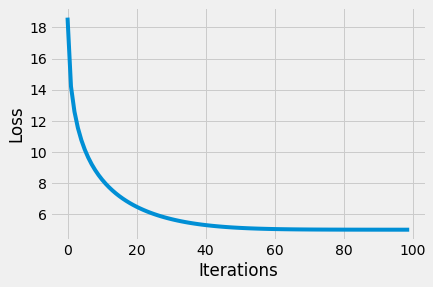

In [19]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss');

In [20]:
theta

DeviceArray(0.79672338, dtype=float64, weak_type=True)

### Beta distribution

pdf of Beta distribution is defined as,

$$
p(\theta|\alpha, \beta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha,\beta)}, \alpha,\beta>0\\
\text{Where, }B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}\\
\text{and }\Gamma(\alpha) = (\alpha-1)!
$$

In [21]:
beta = tfd.Beta(2.0, 2.0)
beta.prob(0.4)

DeviceArray(1.4400012, dtype=float32)

In [22]:
@interact(a=(0, 10, 0.5), b=(0, 10, 0.5))
def beta_pdf(a, b):
  beta = tfd.Beta(a, b)
  theta_range = jnp.linspace(0.01, 0.99, 100)
  probs = beta.prob(theta_range)
  plt.plot(theta_range, probs)
  plt.xlabel(r"$\theta$")
  plt.ylabel(r"$p(\theta)$");

interactive(children=(FloatSlider(value=5.0, description='a', max=10.0, step=0.5), FloatSlider(value=5.0, desc…

### Coin Toss (Maximum A Posteriori estimation (MAP))

\begin{align}
p(\theta|D)p(\theta) &= \theta^h(1-\theta)^{N-h}\cdot\frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}\\
                     &= \frac{\theta^{h+\alpha-1}(1-\theta)^{N-h+\beta-1}}{B(\alpha, \beta)}\\
\log p(\theta|D)p(\theta) &= (h+\alpha-1)\log(\theta) + (N-h+\beta-1)\log(1-\theta) - \log(B(\alpha, \beta))\\
\\
\frac{d}{d\theta} \log p(\theta|D)p(\theta) &= \frac{h+\alpha-1}{\theta} - \frac{N-h+\beta-1}{1-\theta} = 0\\
\\
\theta_{MAP} &= \frac{h+(\alpha-1)}{N+(\alpha-1)+(\beta-1)}
\end{align}

In [23]:
alpha = 1.0
beta = 2.0
h = (coin_toss_data == 1).sum()
N = len(coin_toss_data)

theta_map = (h + (alpha - 1)) / (N + (alpha -1) + (beta - 1))
theta_map

DeviceArray(0.72727273, dtype=float64, weak_type=True)

### MAP (Solution via optimization)

In [24]:
def neg_log_joint_fn(theta, data):
  prior = tfd.Beta(alpha, beta)
  neg_log_prior = -prior.log_prob(theta)
  neg_log_likelihood = neg_log_likelihood_fn(theta, data)
  return neg_log_prior + neg_log_likelihood

In [25]:
grad_fn = jax.grad(neg_log_joint_fn)
theta = 0.1
n_iters = 100
learning_rate = 0.001

losses = []
for iteration in range(n_iters):
  loss = neg_log_joint_fn(theta, coin_toss_data)
  losses.append(loss)

  grad = grad_fn(theta, coin_toss_data)
  theta = theta - learning_rate * grad

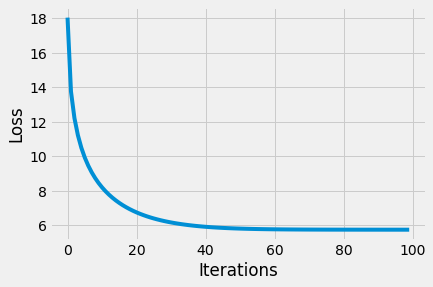

In [26]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss');

In [27]:
theta

DeviceArray(0.72409419, dtype=float64, weak_type=True)

### Coin toss posterior

#### Derive the evidence

\begin{align}
p(D) &= \int\limits_{0}^{1}p(D|\theta)p(\theta)d\theta\\
     &= \int\limits_{0}^{1}(\theta)^h(1-\theta)^{N-h}\frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha,\beta)}d\theta\\
     &= \frac{1}{B(\alpha,\beta)}\int\limits_{0}^{1}(\theta)^{h+\alpha-1}(1-\theta)^{N-h+\beta-1}\\
     &= \frac{1}{B(\alpha,\beta)}\frac{(h+\alpha-1)!(N-h+\beta-1)!}{(N+\alpha+\beta-1)!}
\end{align}

#### Derive posterior

\begin{align}
p(\theta|D) = \frac{p(D|\theta)}{p(D)}p(\theta)&=B(\alpha,\beta)\frac{(N+\alpha+\beta-1)!}{(h+\alpha-1)!(N-h+\beta-1)!}\frac{\theta^{h+\alpha-1}(1-\theta)^{N-h+\beta-1}}{B(\alpha, \beta)}\\
\\
&= Beta(h+\alpha, N-h+\beta)
\end{align}

## Linear regression

### Generative process

In [28]:
x = jnp.linspace(-1, 1, 10)
real_slope = 3
real_intercept = 4
f = real_slope * x + real_intercept
noise_scale = 1.0
likelihood_distribution = tfd.Normal(loc=f, scale=noise_scale)

In [29]:
@interact(seed=(0,10))
def generate_data(seed):
  seed = jax.random.PRNGKey(seed)
  y = likelihood_distribution.sample(seed=seed)
  plt.scatter(x, y)
  plt.xlabel('x')
  plt.ylabel('y');
  plt.ylim(0,8);

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

### Generate data

In [30]:
seed = jax.random.PRNGKey(5)
y = likelihood_distribution.sample(seed=seed)

### Maximum Likelihood Estimation (Analytic solution)

\begin{equation}
p(\mathbf{y}|X, \boldsymbol{\theta}) = \frac{1}{\sqrt{(2\pi)^n |\sigma^2I|}}\exp \left( (\mathbf{y} - X\boldsymbol{\theta})^T(\sigma^2I)^{-1}(\mathbf{y} - X\boldsymbol{\theta}) \right)
\end{equation}

Simplifying the above equation:

\begin{equation}
p(\mathbf{y}|X, \boldsymbol{\theta}) = \frac{1}{(2\pi\sigma^2)^{\frac{n}{2}}}\exp \left( \sigma^{-2}(\mathbf{y} - X\boldsymbol{\theta})^T(\mathbf{y} - X\boldsymbol{\theta}) \right)
\end{equation}

Taking log to simplify further:

\begin{align}
\log p(\mathbf{y}|X, \boldsymbol{\theta}) &= (\mathbf{y} - X\boldsymbol{\theta})^T(\mathbf{y} - X\boldsymbol{\theta}) + \log \sigma^{-2} + \log \frac{1}{(2\pi\sigma^2)^{\frac{n}{2}}}\\
\frac{d}{d\boldsymbol{\theta}} \log p(\mathbf{y}|X, \boldsymbol{\theta}) &= \frac{d}{d\boldsymbol{\theta}}(\mathbf{y} - X\boldsymbol{\theta})^T(\mathbf{y} - X\boldsymbol{\theta})\\
&= \frac{d}{d\boldsymbol{\theta}}(\mathbf{y}^T - \boldsymbol{\theta}^TX^T)(\mathbf{y} - X\boldsymbol{\theta})\\
&= \frac{d}{d\boldsymbol{\theta}} \left[ \mathbf{y}^T\mathbf{y} - \mathbf{y}^TX\boldsymbol{\theta} - \boldsymbol{\theta}^TX^T\mathbf{y} + \boldsymbol{\theta}^TX^TX\boldsymbol{\theta}\right]\\
&= -(\mathbf{y}^TX)^T - X^T\mathbf{y} + 2X^TX\boldsymbol{\theta} = 0\\
\therefore X^TX\boldsymbol{\theta} &= X^T\mathbf{y}\\
\therefore  \boldsymbol{\theta}_{MLE} &= (X^TX)^{-1}X^T\mathbf{y}
\end{align}

We used some of the formulas from [this cheatsheet](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) but they can also be derived from scratch.

In [31]:
x_extra = jnp.vstack([jnp.ones(len(x)), x]).T
mle_intercept, mle_slope = jnp.linalg.inv(x_extra.T@x_extra)@x_extra.T@y
mle_slope, mle_intercept

(DeviceArray(3.47665753, dtype=float64), DeviceArray(4.2940263, dtype=float64))

### Maximum Likelihood Estimation (Solution by optimization)

In [32]:
def neg_log_likelihood_fn(slope, intercept):
  f = slope * x + intercept
  likelihood = tfd.Normal(loc=f, scale=noise_scale)
  return -likelihood.log_prob(y).sum()

In [33]:
grad_fn = jax.grad(neg_log_likelihood_fn, argnums=(0, 1))
slope = 0.0
intercept = 0.0
n_iters = 100
learning_rate = 0.005

losses = []
for iteration in range(n_iters):
  loss = neg_log_likelihood_fn(slope, intercept)
  losses.append(loss)

  grads = grad_fn(slope, intercept)
  slope = slope - learning_rate * grads[0]
  intercept = intercept - learning_rate * grads[1]

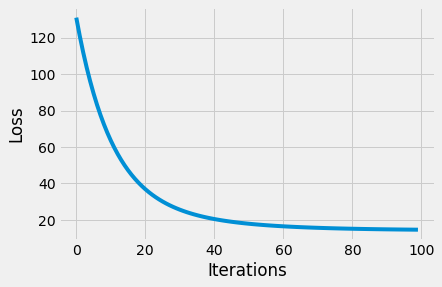

In [34]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss');

In [35]:
slope, intercept

(DeviceArray(3.03268803, dtype=float64, weak_type=True),
 DeviceArray(4.2686034, dtype=float64, weak_type=True))

### Animation of NLL v/s fit

In [36]:
#@title
slopes = jnp.linspace(-1.5,7.5,100)
intercepts = jnp.linspace(-0.5,8.5,100)
slopes, intercepts = jnp.meshgrid(slopes, intercepts)
vectorized_nll_fn = jax.vmap(jax.vmap(neg_log_likelihood_fn))
nlls = vectorized_nll_fn(slopes, intercepts)

@interact(intercept=(0.0, 8.0, 0.5), slope=(-1.0, 7.0, 0.5))
def plot_neg_log_likelihood_and_fit(intercept=0.0, slope=0.0):
  fig, ax = plt.subplots(1, 2, figsize=(12,4))
  nll = neg_log_likelihood_fn(slope, intercept)

  ax[0].scatter(x, y, label='data');
  ax[0].plot(x, slope*x+intercept, label="fit");
  ax[0].legend(loc='upper left');
  ax[0].set_xlabel('x');
  ax[0].set_ylabel('y');

  cl = ax[1].contourf(slopes, intercepts, nlls, levels=10)
  fig.colorbar(cl)
  ax[1].scatter(slope, intercept, label="NLL", zorder=10, c='r', s=100)
  ax[1].legend(loc='upper left');
  ax[1].set_xlabel('slope');
  ax[1].set_ylabel('intercept');

interactive(children=(FloatSlider(value=0.0, description='intercept', max=8.0, step=0.5), FloatSlider(value=0.…

### Prior

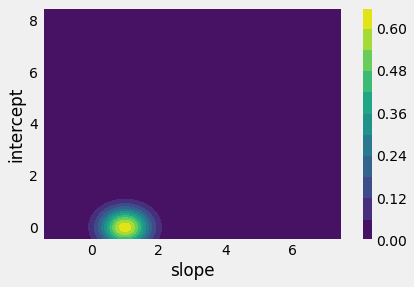

In [37]:
#@title
prior_slope_dist = tfd.Normal(1, 0.5)
prior_intercept_dist = tfd.Normal(0, 0.5)

def prior_prob_fn(slope, intercept):
  prior_slope_prob = prior_slope_dist.prob(slope)
  prior_intercept_prob = prior_intercept_dist.prob(intercept)
  return prior_slope_prob * prior_intercept_prob

vectorized_prior_prob_fn = jax.vmap(jax.vmap(prior_prob_fn))
prior_probs = vectorized_prior_prob_fn(slopes, intercepts)

mappable = plt.contourf(slopes, intercepts, prior_probs, levels=10)
plt.colorbar(mappable);
plt.xlabel('slope')
plt.ylabel('intercept');

### Find MAP with optimization

In [38]:
def neg_log_joint_fn(slope, intercept):
  neg_log_prior = -prior_slope_dist.log_prob(slope) - prior_intercept_dist.log_prob(intercept)
  neg_log_likelihood = neg_log_likelihood_fn(slope, intercept)
  return neg_log_prior + neg_log_likelihood

In [39]:
grad_fn = jax.grad(neg_log_joint_fn, argnums=(0, 1))
slope = 0.0
intercept = 0.0
n_iters = 200
learning_rate = 0.001

losses = []
for iteration in range(n_iters):
  loss = neg_log_joint_fn(slope, intercept)
  losses.append(loss)

  grads = grad_fn(slope, intercept)
  slope = slope - learning_rate * grads[0]
  intercept = intercept - learning_rate * grads[1]

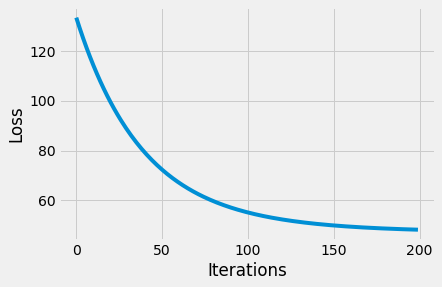

In [40]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss');

In [41]:
slope, intercept

(DeviceArray(1.8050881, dtype=float64, weak_type=True),
 DeviceArray(2.88430125, dtype=float64, weak_type=True))

## MAP v/s MLE on polynomial regression


In [42]:
from sklearn.preprocessing import PolynomialFeatures

In [58]:
poly = PolynomialFeatures(degree=11)
x_poly = poly.fit_transform(x.reshape(-1,1))
d = x_poly.shape[1]
prior_poly = tfd.Normal(loc=jnp.zeros(d), scale=0.3*jnp.ones(d))

In [59]:
def neg_log_likelihood_fn(theta):
  f = x_poly@theta
  noise_scale = 0.5
  likelihood = tfd.Normal(f, scale=noise_scale)
  return -(likelihood.log_prob(y).sum())

def neg_log_joint_fn(theta):
  neg_log_prior = -(prior_poly.log_prob(theta).sum())
  neg_log_likelihood = neg_log_likelihood_fn(theta)
  return neg_log_likelihood + neg_log_prior

In [60]:
mle_value_and_grad_fn = jax.value_and_grad(neg_log_likelihood_fn)
map_value_and_grad_fn = jax.value_and_grad(neg_log_joint_fn)
theta_mle = jnp.ones(x_poly.shape[1])
theta_map = jnp.ones(x_poly.shape[1])
n_iters = 200
learning_rate = 0.001

mle_losses = []
map_losses = []
for iteration in range(n_iters):
  mle_loss, mle_grads = mle_value_and_grad_fn(theta_mle)
  map_loss, map_grads = map_value_and_grad_fn(theta_map)
  mle_losses.append(mle_loss)
  map_losses.append(map_loss)
  theta_mle = theta_mle - learning_rate * mle_grads
  theta_map = theta_map - learning_rate * map_grads

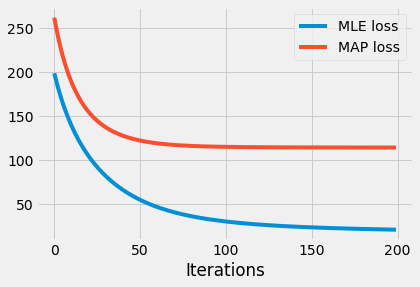

In [61]:
plt.plot(mle_losses, label='MLE loss')
plt.plot(map_losses, label='MAP loss')
plt.xlabel('Iterations')
plt.legend();

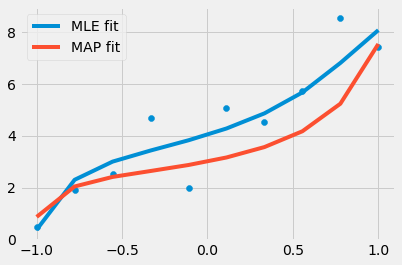

In [62]:
plt.scatter(x, y)
plt.plot(x, x_poly@theta_mle, label='MLE fit');
plt.plot(x, x_poly@theta_map, label='MAP fit');
plt.legend();

In [66]:
jnp.linalg.norm(theta_mle)

DeviceArray(4.80030368, dtype=float64)

In [67]:
jnp.linalg.norm(theta_map)

DeviceArray(3.54093073, dtype=float64)